In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import lz4.frame as lz4f
import cloudpickle as cpkl
import json
import re
import os

import uproot
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot, export

In [2]:
import sys
print(sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [3]:
with lz4f.open("hists_2018QCD.cpkl.lz4") as fin:
    hists_unmapped = cpkl.load(fin)

In [4]:
print(hists_unmapped.items())


dict_items([('sumw', {'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': <fnal_column_analysis_tools.processor.accumulator.accumulator object at 0x7fa2a563f780>, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': <fnal_column_analysis_tools.processor.accumulator.accumulator object at 0x7fa2d03ee9e8>, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8': <fnal_column_analysis_tools.processor.accumulator.accumulator object at 0x7fa2a178ba20>, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': <fnal_column_analysis_tools.processor.accumulator.accumulator object at 0x7fa2d03eeb00>, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': <fnal_column_analysis_tools.processor.accumulator.accumulator object at 0x7fa2a178b9b0>}), ('ddtmaping_preselection', <Hist (dataset,AK8Puppijet0_isHadronicV,AK8Puppijet0_pt,ak8jet_rho,AK8Puppijet0_N2sdb1) instance at 0x7fa2a178bd68>)])


In [6]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = "dataset"

process_map = OrderedDict()
process_map["QCD"] = [
    "QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8",
    "QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8",
]

hists = {}

for key, val in hists_unmapped.items():
    if isinstance(val, hist.Hist):
        hists[key] = val.group(process, process_cats, process_map)
        
print(hists.items())        

dict_items([('ddtmaping_preselection', <Hist (process,AK8Puppijet0_isHadronicV,AK8Puppijet0_pt,ak8jet_rho,AK8Puppijet0_N2sdb1) instance at 0x7fa29e60e8d0>)])


In [5]:
histo = hists['ddtmaping_preselection'].sum('AK8Puppijet0_isHadronicV', overflow='all')
val_QCD = histo.values(overflow='allnan')[('QCD',)]
qcd_maxval_temp = np.cumsum(val_QCD, axis=2)
qcd_maxval = qcd_maxval_temp[:,:,-1]

norma = qcd_maxval_temp / np.maximum(1e-10,qcd_maxval[:,:,np.newaxis])
print(norma)

[[[0.0000000e+00 4.8540704e-02 4.8792779e-02 ... 9.2921007e-01
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 6.5658212e-04 6.6291826e-04 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 1.9662883e-05 1.9662883e-05 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 5.6193911e-02 5.6416385e-02 ... 9.7970307e-01
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 1.1041544e-04 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
   1.0000000e+00 1.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000

In [6]:
hist_y_QCD = histo.sum("process")
print(hist_y_QCD)
template = hist_y_QCD.sum("AK8Puppijet0_N2sdb1")
print(template)
hist_y_QCD.clear()
hist_y_QCD._sumw = {():norma}

<Hist (AK8Puppijet0_pt,ak8jet_rho,AK8Puppijet0_N2sdb1) instance at 0x7f64a7252b00>
<Hist (AK8Puppijet0_pt,ak8jet_rho) instance at 0x7f64a7252b38>


In [7]:
import scipy.ndimage as sc
res = np.apply_along_axis(lambda norma: norma.searchsorted(0.26), axis = 2, arr = norma)
print(res.shape)
res[res>100]=0
print(hist_y_QCD.identifiers("AK8Puppijet0_N2sdb1"))
def bineval(a):
    return hist_y_QCD.identifiers("AK8Puppijet0_N2sdb1")[a].lo
print(bineval(55))
binfunc = np.vectorize(bineval)
qmap = binfunc(res)
print(qmap.shape)
smooth_qmap = sc.filters.gaussian_filter(qmap,1)

(103, 55)
[<Interval ([0, 0.005)) instance at 0x7f64a7249fd0>, <Interval ([0.005, 0.01)) instance at 0x7f64a724d048>, <Interval ([0.01, 0.015)) instance at 0x7f64a724d080>, <Interval ([0.015, 0.02)) instance at 0x7f64a724d0b8>, <Interval ([0.02, 0.025)) instance at 0x7f64a724d0f0>, <Interval ([0.025, 0.03)) instance at 0x7f64a724d128>, <Interval ([0.03, 0.035)) instance at 0x7f64a724d160>, <Interval ([0.035, 0.04)) instance at 0x7f64a724d198>, <Interval ([0.04, 0.045)) instance at 0x7f64a724d1d0>, <Interval ([0.045, 0.05)) instance at 0x7f64a724d208>, <Interval ([0.05, 0.055)) instance at 0x7f64a724d240>, <Interval ([0.055, 0.06)) instance at 0x7f64a724d278>, <Interval ([0.06, 0.065)) instance at 0x7f64a724d2b0>, <Interval ([0.065, 0.07)) instance at 0x7f64a724d2e8>, <Interval ([0.07, 0.075)) instance at 0x7f64a724d320>, <Interval ([0.075, 0.08)) instance at 0x7f64a724d358>, <Interval ([0.08, 0.085)) instance at 0x7f64a724d390>, <Interval ([0.085, 0.09)) instance at 0x7f64a724d3c8>, <I

In [8]:
template.clear()
template._sumw = {():smooth_qmap}
template.label = 'N2 cut at 26%'

values_nonan = template.values()[()]
print(template)

print(values_nonan)

<Hist (AK8Puppijet0_pt,ak8jet_rho) instance at 0x7f64a7252b38>
[[0.30946268 0.32761681 0.33172148 ... 0.28968517 0.28586817 0.26920454]
 [0.30611105 0.32429537 0.32831577 ... 0.28527384 0.28138003 0.2649216 ]
 [0.30374008 0.32200517 0.326278   ... 0.28154127 0.27778591 0.26152176]
 ...
 [0.21313664 0.22952074 0.23207208 ... 0.18421741 0.18102255 0.17015341]
 [0.21012607 0.2261419  0.22963983 ... 0.17805699 0.17561906 0.16538448]
 [0.1963503  0.21152624 0.21562893 ... 0.16701091 0.16321363 0.15289368]]


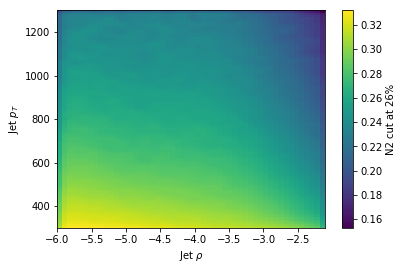

In [10]:
fig3, ax3, _ = plot.plot2d(template, xaxis="ak8jet_rho", patch_opts={})

fig3.savefig("plots/N2DDT_26_2018bits_GaussianSmoothing1Sigma_CorrectVersion.pdf")
fig3.savefig("plots/N2DDT_26_2018bits_GaussianSmoothing1Sigma_CorrectVersion.png")
fig3.savefig("plots/N2DDT_26_2018bits_GaussianSmoothing1Sigma_CorrectVersion.svg")

In [11]:
import ROOT
outfile = ROOT.TFile("plots/n2ddtmap_2018bits_GaussianSmoothing1Sigma_CorrectVersion.root","recreate")
outfile.cd()
print(values_nonan.shape)
h1 = ROOT.TH2F("h1","h1",52, -6, -2.1, 100, 300, 1300)
for i in range(h1.GetNbinsX()):
    for j in range(h1.GetNbinsY()):
        h1.SetBinContent(i+1,j+1,values_nonan[j][i])
h1.Write()
outfile.Close()

Welcome to JupyROOT 6.16/00
(100, 52)
